In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from pymatgen.analysis import magnetism
import tqdm
from mat2vec.processing import MaterialsTextProcessor

In [2]:
Elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 
    'S','Cl','Ar','K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
    'Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
    'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce',
    'Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf',
    'Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
    'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm',
    'Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Uut',
    'Fl','Uup','Lv','Uus','Uuo']

In [3]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [4]:
SuperCon = pd.read_excel('new_supercon.xlsx')

In [5]:
SuperCon = SuperCon[['element', 'tc', 'year.1']]
SuperCon.rename(columns = {'element':'Components'}, inplace = True)
SuperCon.rename(columns = {'tc':'Tc'}, inplace = True)
SuperCon.rename(columns = {'year.1':'year'}, inplace = True)

In [6]:
for i in range(len(SuperCon)):
    if '-' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN

for i in range(len(SuperCon)):
    if ',' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN
        
for i in range(len(SuperCon)):
    if '+' in SuperCon['Components'].iloc[i]:
        SuperCon['Tc'][i] = np.NaN

C:\Users\giovanni\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\giovanni\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\giovanni\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [7]:
import re
S2 = set(Elements)

for i in range(len(SuperCon)):
    list_1 = re.findall('[A-Z][a-z]|[A-Z]', SuperCon['Components'].iloc[i])
    S1 = set(list_1)
    
    if len(S1) > len(S1.intersection(S2)):
        if not SuperCon['Tc'].isna().iloc[i]:
            print(SuperCon['Components'].iloc[i])

            SuperCon['Tc'].iloc[i] = np.NaN

Yb16Ba1Cu2Oz
Yb1.8Ba0.2Cu1Oz
Yb6Ba1Cu1Oz
Yb1.62La0.18Ba0.18Sr0.02Cu1Oz
Y0.4Ba0.6Cu1OX
Y0.4Ba0.6Cu1OX
Er0.5Ba0.5Cu1OX
Tm0.35Ba0.65Cu1OX
Tm0.3Ba0.7Cu1OX
Tm0.25Ba0.75Cu1OX
Tm0.2Ba0.8Cu1OX
Y1Ba2Cu3OX
Nd0.4Ba0.6Cu1OX
Nd2Ba3Cu5OX
Sm1Ba2Cu3OX
Gd2Ba3Cu5OX
Y1Ba2Cu3OX
Y1Ba2Cu3OX
Y0.8Ba1.2Cu1OX
Y0.6Ba0.9Cu1OX
Yb1.6La0.2Ba0.2Cu1Oz
Y0.4Ba0.6Cu1OX
Er1Ba2Cu3OX
Ho1Ba2Cu3OX
Gd1Ba2Cu3OX
Eu1.5Ba1.5Cu3Oz
Gd1.5Ba1.5Cu3Oz
Y1.5Ba1.5Cu3Oz
Yb1.5Ba1.5Cu3Oz
Y1Ba2Cu3F0.066Oz
Y1Ba2Cu3F0.066Oz
Y1Ba2Cu3F0.165Oz
Y1Ba2Cu3F0.016Oz
Y1Ba2Cu3F0.033Oz
Y1Ba2Cu3F0.05Oz
Y1Ba2Cu3Oz
Y1Ba2Cu3Oz
Gd1Ba2Cu3Oz
Er1Ba2Cu3OX
Dy1Ba2Cu3OX
Ho1Ba2Cu3OX
Y1Ba2Cu3OX
La1.85Sr0.15Cu0.97Ni0.03OX
Tl2Ca2Ba1Cu3OX
Tl2Ca2Ba2Cu3OX
Y1Ba2Cu3Oz
Y1Ba2Cu2.85Ti0.15Oz
Y1Ba2Cu2.7Ti0.3Oz
Y1Ba2Cu2.55Ti0.45Oz
Y1Ba2Cu2.4Ti0.6Oz
Y1Ba2Cu2.25Ti0.75Oz
Y1Ba2Cu2.1Ti0.9Oz
Bi1Sr1Ca1Cu2Oz
Bi2Sr1.8Ca1.2Cu2Oz
Bi2Sr3Ca4Cu8Oz
Bi1Sr1Ca1Cu2Oz
Gd1Ba2Cu3OX
Gd1Ba1.8Sr0.2Cu3OX
Gd1Ba1.6Sr0.4Cu3OX
Gd1Ba1.4Sr0.6Cu3Oz
Gd1Ba1.2Sr0.8Cu3Oz
Gd1Ba1Sr1Cu3Oz
Bi1Ca1Sr1Cu2Oz
Bi1Ca1Sr1Cu2Oz
Eu1B

C:\Users\giovanni\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Tl2.5Pb0.5Nd1Sr2Cu2.5OX
Tl2.5Pb0.6Nd1Sr2Cu2.5OX
Tl2.5Pb0.7Nd1Sr2Cu2.5OX
Tl2.5Pb1Nd1Sr2Cu2.5OX
Tl2.5Pb0.3Pr1Sr2Cu2.5OX
Tl2.5Pb0.5Pr1Sr2Cu2.5OX
Tl2.5Pb0.65Pr1Sr2Cu2.5OX
Tl2.5Pb0.8Pr1Sr2Cu2.5OX
Tl2.5Pb1Pr1Sr2Cu2.5OX
Ba1Y0.67La0.33Cu1.8Li0.2OX
Tl1.5Pb0.3Nd2Sr2Cu2OX
Tl1.5Pb0.5Nd2Sr2Cu2OX
Tl1.5Pb0.7Nd2Sr2Cu2OX
Tl1.5Pb1Nd2Sr2Cu2OX
Tl1.5Pb0.5Sm2Sr2Cu2OX
Tl1.5Pb0.5Pr2Sr2Cu2OX
Tl1.5Nd1Sr2Cu3OX
Tl1.5Nd2Sr2Cu3OX
Tl1.5Pb0.5Nd1Sr2Cu3OX
Tl1.5Pb0.5Nd2Sr2Cu3OX
Tl1.5Nd2Sr2Cu2OX
La1.92Sr0.08Cu1OZ
La1.88Sr0.12Cu1OZ
La1.84Sr0.16Cu1OZ
La1.8Sr0.2Cu1OZ
La1.76Sr0.24Cu1OZ
Tl2Ba2Ca2Cu3OX
Bi2Sr2Ca2Cu2OX
Y1Ba2Cu3OZ
La1Ba2Cu3OZ
Nd1Ba2Cu3OZ
Sm1Ba2Cu3OZ
Eu1Ba2Cu3OZ
Dy1Ba2Cu3OZ
Ho1Ba2Cu3OZ
Er1Ba2Cu3OZ
Tm1Ba2Cu3OZ
Bi2Sr2Ca1Cu2OZ
Bi2Sr2Ca1Cu2OX
Tl2Ba2Ca2Cu3OX
Tl2Ba2Ca1Cu2OX
Tl2Ba2Cu1OX
Y1Ba2Cu3OX
Bi4.1Sr2.4Ca2.4Cu4OX
Bi1.7Pb0.2Sb0.1Sr2Ca2Cu3OZ
Bi1.6Pb0.3Sb0.1Sr2Ca2Cu3OZ
Bi1.5Pb0.4Sb0.1Sr2Ca2Cu3OZ
Bi1.4Pb0.5Sb0.1Sr2Ca2Cu3OZ
Tl0.5Pb0.5Ca0.8Er0.2Sr2Cu2OX
Tl5Ba5Ca2Cu6OX
Bi2Sr2Ca2Cu3OX
Tm1Ba2Cu3OZ
Gd1Ba2Cu3OZ
Dy1Ba2Cu3OZ
Ho1

In [8]:
SuperCon = SuperCon.dropna(axis = 0)
SuperCon = SuperCon.sort_values('Tc', ascending = False)

In [9]:
import tqdm
normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(SuperCon))):
    SuperCon['Components'].iloc[i] = normalizer.normalized_formula(SuperCon['Components'].iloc[i])
    #print(i/len(SuperCon)*100)

100%|██████████████████████████████████████████████████████████████████████████| 20678/20678 [00:10<00:00, 1919.68it/s]


In [10]:
grouped_df = SuperCon.groupby('Components')
grouped_Tc = grouped_df['Tc'].apply(list).reset_index()
grouped_year = grouped_df['year'].apply(list).reset_index()
grouped_Tc['year'] = grouped_year['year']

In [11]:
grouped = grouped_Tc

In [12]:
grouped

,Components,Tc,year
0,Ag10Bi3Se20Sn7,[4.0],[2017.0]
1,Ag10BiSe20Sn9,[5.2],[2017.0]
2,Ag10Sn87Te100,"[1.88, 1.78]","[1973.0, 1973.0]"
3,Ag11Bi60Pb39Se140,[1.7],[2014.0]
4,Ag13Al7,[0.1],[1970.0]
...,...,...,...
13218,Y,"[19.5, 17.0, 2.7, 2.7, 2.5, 1.8]","[2007.0, 2006.0, 1972.0, 1970.0, 1974.0, 1974.0]"
13219,Yb,[1.04],[2018.0]
13220,Zn,"[0.867, 0.857, 0.855, 0.85, 0.825]","[1966.0, 1971.0, 1967.0, 1966.0, 1958.0]"
13221,Zn2Zr,"[0.6, 0.29]","[2005.0, 2001.0]"


In [13]:
grouped['len'] = 0
grouped['mean'] = 0
grouped['weighted_mean'] = 0 
grouped['std'] = 0
grouped['rsd'] = 0
for i in tqdm.tqdm(range(len(grouped))):
    grouped['len'].iloc[i] = len(grouped['Tc'].iloc[i])
    grouped['mean'].iloc[i] = np.mean(grouped['Tc'].iloc[i])
    grouped['weighted_mean'].iloc[i] = np.dot(np.array(grouped.iloc[i]['year']) - 1900, grouped.iloc[i]['Tc'])/sum(np.array(grouped.iloc[i]['year']) - 1900)
    grouped['std'].iloc[i] = np.std(grouped['Tc'].iloc[i])
    grouped['rsd'].iloc[i] = 100*np.std(grouped['Tc'].iloc[i])/np.mean(grouped['Tc'].iloc[i])

  0%|                                                                                        | 0/13223 [00:00<?, ?it/s]C:\Users\giovanni\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
  1%|▊                                                                            | 148/13223 [00:00<00:17, 742.58it/s]C:\Users\giovanni\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
100%|███████████████████████████████████████████████████████████████████████████| 13223/13223 [00:17<00:00, 774.20it/s]


In [14]:
grouped = grouped[['Components', 'mean']]
grouped.columns = ['Components', 'Tc']

### Dataset construction

In [15]:
Elements = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P',
    'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru',
    'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce',
    'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf',
    'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn',
    'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh',
    'Fl', 'Mc', 'Lv', 'Ts', 'Og']

In [16]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen

    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):

    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [17]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

C:\Users\giovanni\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
Data_train = featurizing(grouped)

MultipleFeaturizer:   0%|          | 0/13223 [00:00<?, ?it/s]

In [19]:
Data_train['Tc'] = grouped.set_index('Components')['Tc']

In [20]:
Data_train = Data_train.dropna()

In [21]:
train_df, test_df = train_test_split(Data_train, test_size=0.2, random_state=0)

## Pipeline Hypertuning

In [22]:
etr = ExtraTreesRegressor(random_state = 0)

pipe = Pipeline([
    ('decorrelation', MyDecorrelator(0.9)), 
    ('threshold', VarianceThreshold(threshold = 0)), 
    ('feature_selector', SelectPercentile(f_regression)), 
    ('etr', etr)
], verbose = 1)

In [23]:
param_grid = {
    "etr__n_estimators": [100, 250, 500],              #Tune the number of estimators
    "etr__max_features": [1, 0.75, 0.5],               #Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [100, 75, 50]      #Tune the percentage of features to retain in terms of f_regression score
}
search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = 5)

In [24]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 27.6min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.7s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.1s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  18.3s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_selector',
                                        SelectPercentile(percentile=10,
                                                         score_func=<function f_regression at 0x000002063521F0D8>)),
                                       ('etr',
                                        ExtraTreesRegressor(bootstrap=False,
                                                            ccp_alpha=0.0,
                                                            criterion='mse',
                                                            max_d...
                                                            min_weight

In [25]:
search.best_params_

{'etr__max_features': 0.5,
 'etr__n_estimators': 250,
 'feature_selector__percentile': 100}

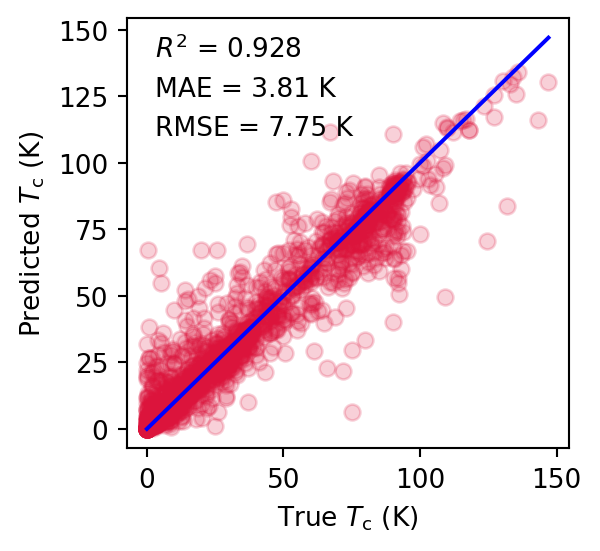

In [26]:
test_predictions = search.predict(test_df.iloc[:, :-1])
test_labels = test_df.iloc[:, -1].values


test_predictions = search.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error

delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

## Manual refit & SHAP analysis

In [27]:
X_train = train_df.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df.iloc[:, :-1]).get_support()]
X_test = test_df[X_train.columns]

correlated_features = set()  
corr_matrix = X_train.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)
            
X_train = X_train.drop(labels=correlated_features, axis=1)
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

In [28]:
X_train

,0-norm,2-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,...,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData mean GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData mean SpaceGroupNumber,compound possible,avg ionic char
Components,,,,,,,,,,,,,,,,,,,,,
Ce3Cu10Eu7O50Ru5Sr10,6.0,0.620637,8.0,63.0,55.0,22.411765,16.955017,8.0,8.0,87.0,...,0.000,0.0,0.000000,0.000000,0.000000,12.0,229.0,97.117647,False,0.155164
Hf5Rh4Ti91,3.0,0.912250,22.0,72.0,50.0,25.420000,6.224400,22.0,43.0,59.0,...,0.000,0.0,0.000023,0.000021,0.000023,194.0,225.0,195.240000,False,0.005735
Ba2000Cu3500O7361Pr200Tm800,5.0,0.608393,8.0,69.0,61.0,24.485102,17.509103,8.0,9.0,87.0,...,0.000,0.0,0.000000,0.000000,0.000000,12.0,229.0,110.225236,False,0.159042
Ba39CoCu59O140Y20,5.0,0.610515,8.0,56.0,48.0,22.478764,15.652718,8.0,9.0,87.0,...,0.000,0.0,1.548471,0.005979,0.000000,12.0,229.0,107.953668,False,0.161080
Ce19Co20In100La,4.0,0.741000,27.0,58.0,31.0,47.135714,5.753061,49.0,13.0,75.0,...,0.000,0.0,1.548471,0.221210,0.000000,139.0,194.0,154.714286,False,0.013565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TcTi3,2.0,0.790569,22.0,43.0,21.0,27.250000,7.875000,22.0,43.0,53.0,...,0.000,0.0,0.000023,0.000017,0.000023,194.0,194.0,194.000000,False,0.005978
Ba10CaCu20O40Y4,5.0,0.613478,8.0,56.0,48.0,21.813333,14.782578,8.0,7.0,87.0,...,0.000,0.0,0.000000,0.000000,0.000000,12.0,229.0,110.280000,False,0.156797
FeMo12499,2.0,0.999920,26.0,42.0,16.0,41.998720,0.002560,42.0,50.0,55.0,...,0.000,0.0,2.110663,0.000169,0.000000,229.0,229.0,229.000000,False,0.000002


In [31]:
etr = ExtraTreesRegressor(random_state=0, n_estimators = 250, max_features = 0.5)
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.5, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=250, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

In [32]:
y_predictions = etr.predict(X_test)

In [34]:
import shap
explainer = shap.TreeExplainer(etr)
shap_values = explainer.shap_values(X_test)

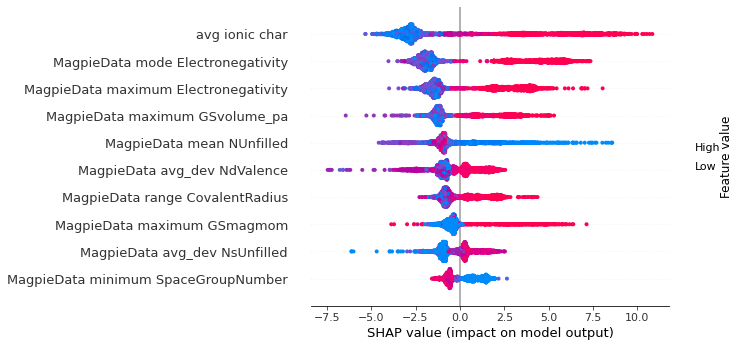

In [35]:
shap.summary_plot(shap_values, X_test, max_display = 10)

In [36]:
Output_shap = pd.DataFrame(shap_values, index = X_test.index, columns = X_test.columns)

In [37]:
Output_shap_mean = pd.DataFrame(abs(Output_shap).describe().loc['mean']/sum(abs(Output_shap).describe().loc['mean'])).sort_values('mean', ascending = False)

In [38]:
Output_shap_mean.to_excel('SHAP.xlsx')
shaps = pd.read_excel('SHAP.xlsx')

In [40]:
import pandas as pd

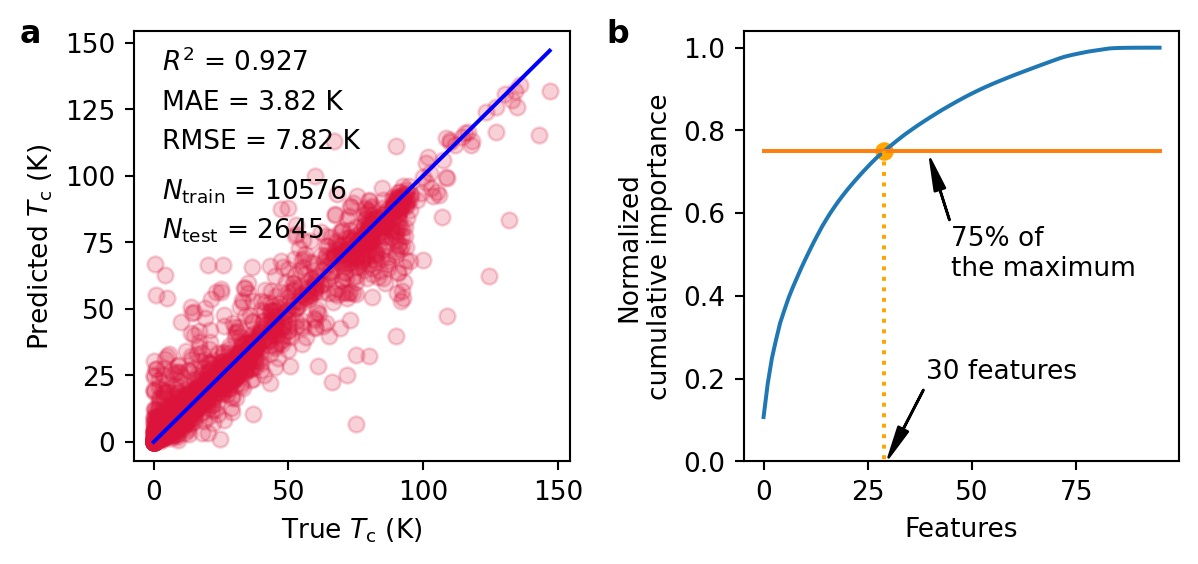

In [48]:
N = np.shape(X_test)[1]
k = 0.75
import matplotlib.pyplot as plt
normalized_cumulative = np.cumsum(shaps['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.1, 3), dpi = 190)                                                                                       
ax1.scatter(y_test, y_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
ax1.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
ax1.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
ax1.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)

ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % len(train_df), xy=(0.02 * delta, 0.62 * delta), xytext=(0.02 * delta, 0.62 * delta),
            )
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), xy=(0.02 * delta, 0.52 * delta), xytext=(0.02 * delta, 0.52 * delta),
            )
ax1.annotate(r'$\mathbf{a}$', xy=(0, 0), xytext=(-50, 150), fontsize = 12,
            )

ax1.set_xlabel("True $T_\mathrm{c}$ (K)")
ax1.set_ylabel("Predicted $T_\mathrm{c}$ (K)")


ax2.plot(np.arange(N), normalized_cumulative)
ax2.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k*max(normalized_cumulative)*np.ones(N)))
ax2.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax2.annotate('75% of\nthe maximum', xy=(40, 0.73), xytext=(45, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax2.scatter(ind_cross1, normalized_cumulative[ind_cross1], color = 'orange')
ax2.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color = 'orange', ls = ':')
ax2.set_ylim(0, 1.04)
ax2.set_xlabel('Features')
ax2.set_ylabel('Normalized\ncumulative importance')
ax1.annotate(r'$\mathbf{b}$', xy=(0, 0), xytext=(168, 150), fontsize = 12,
            )

plt.subplots_adjust(wspace=0.4)
plt.show()

In [2]:
from joblib import dump, load
import joblib

In [125]:
search = joblib.load('LK99_model_2.joblib')
joblib.dump(search, 'LK99_model_2.joblib')

['LK99_model_2.joblib']

In [9]:
from mat2vec.processing import MaterialsTextProcessor
text_processor = MaterialsTextProcessor()

In [17]:
f = pd.DataFrame(['Cu9O250P60Pb91'], columns = ['Components'])
d = pd.DataFrame(['CuO25P6Pb9'], columns = ['Components'])
b = featurizing(f)
a = featurizing(d)

print(search.predict(b)
, search.predict(a))

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

[8.40839612] [8.23478572]
